https://www.kaggle.com/ekrembayar/homecredit-default-risk-step-by-step-1st-notebook/notebook

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Chargement des bibliothèques nécessaires

In [ ]:


# Chargement des bibliothèques nécessaires
# -----------------------------------------------------------
# Base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Model
from lightgbm import LGBMClassifier

import os
import shutil
import re
import copy
from zipfile import ZipFile
from os import listdir
from pathlib import Path
import glob
from sklearn.preprocessing import OneHotEncoder
# Configuration
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format



## Functions utilisées

In [ ]:
# Categorical Variables & Target
def cat_analyzer(dataframe, variable, target = None):
    print(variable)
    if target == None:
        print(pd.DataFrame({
            "COUNT": dataframe[variable].value_counts(),
            "RATIO": dataframe[variable].value_counts() / len(dataframe)}), end="\n\n\n")
    else:
        temp = dataframe[dataframe[target].isnull() == False]
        print(pd.DataFrame({
            "COUNT":dataframe[variable].value_counts(),
            "RATIO":dataframe[variable].value_counts() / len(dataframe),
            "TARGET_COUNT":dataframe.groupby(variable)[target].count(),
            "TARGET_MEAN":temp.groupby(variable)[target].mean(),
            "TARGET_MEDIAN":temp.groupby(variable)[target].median(),
            "TARGET_STD":temp.groupby(variable)[target].std()}), end="\n\n\n")

# Missing Value
def missing_values(data, table,data2use,threshold):
    cols_remove = data.columns[data.isnull().sum()/data.isnull().count()*100 >= threshold]

    mst = pd.DataFrame(
        {"Num_Missing": data.isnull().sum(), "Missing_perc": data.isnull().sum()/data.isnull().count()*100}).sort_values(
        "Num_Missing", ascending=False)
    mst["DataTypes"] = data[mst.index].dtypes.values
    mst = mst[mst.Missing_perc > threshold].reset_index().rename({"index": "Feature"}, axis=1)

    data2use[table]= data.drop(cols_remove,axis=1)
    if not mst.empty:
        plt.gcf().set_size_inches(10,5)
        #sns.barplot(mst.Feature, mst.Missing_perc).set_title(table)
        sns.stripplot(mst.Feature, mst.Missing_perc).set_title(table)
        plt.xticks(rotation=90, ha='right')
        plt.show()

    return data2use 
    

# One-hot encoding for categorical columns ws
def convert_categorical2numeric(data2use,table):
    for col in list(data2use[table].columns):
        if data2use[table][col].dtype == 'object':
            print(col)
            enc = OneHotEncoder(handle_unknown='ignore')
            totransf=data2use[table][col].values.reshape(-1, 1)
            transf=pd.DataFrame(enc.fit_transform(totransf).toarray())
            
            for knx in transf.columns:
                newname=str(col) + '_'+ str(knx)
                df2= transf.rename({knx:newname}, axis=1) 
                df2=df2.drop(knx)
                #import pdb; pdb.set_trace()
                data2use[table]=data2use[table].join(df2[newname])
               
            data2use[table]=data2use[table].drop(col, axis=1)
            
    return data2use

def fill_remain_missing_val(data2use,table):
    for tnx in data2use[table].columns:
        tofill= data2use[table][tnx].mean()
        data2use[table][tnx] = data2use[table][tnx].fillna(tofill)
    return data2use

def remove_outliers(data2use,table):
    q1value=0.05
    q3value=0.95
    df_final=data2use[table]
    q1 =df_final.quantile(q1value)
    q3 =df_final.quantile(q3value)
    iqr = q3-q1  
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_final = df_final[~((df_final < fence_low) |(df_final > fence_high)).any(axis=1)]
    data2use[table]=df_final
    return data2use

def plot_heatmap(corr, title, figsize=(8, 4), vmin=-1, vmax=1, center=0,
                 palette=sns.color_palette("coolwarm", 20), shape='rect',
                 fmt='.2f', annot=True, robust=False, fig=None, ax=None):

    fig = plt.figure(figsize=figsize) if fig is None else fig
    ax = fig.add_subplot(111) if ax is None else ax

    if shape == 'rect':
        mask = None
    elif shape == 'tri':
        mask = np.zeros_like(corr, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
    else:
        mask = None
        print('ERROR : this type of heatmap does not exist')

    ax = sns.heatmap(corr, mask=mask, cmap=palette, vmin=vmin, vmax=vmax,
                     center=center, annot=annot, annot_kws={"size": 10}, fmt=fmt,
                     square=False, linewidths=.5, linecolor='white',
                     cbar_kws={"shrink": .9, 'label': None}, robust=robust,
                     xticklabels=corr.columns, yticklabels=corr.index,
                     ax=ax)
    ax.tick_params(labelsize=10, top=False, bottom=True,
                   labeltop=False, labelbottom=True)
    ax.collections[0].colorbar.ax.tick_params(labelsize=10)
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
    ax.set_title(title, fontweight='bold', fontsize=12)

## Données

In [ ]:
dir_data = Path('/content/drive/MyDrive/Data_Scientist/DATA/P7') 
dir_data_out = Path('/content/drive/MyDrive/Data_Scientist/DATA/P7_inter') 
dir_fig  = Path('/content/drive/MyDrive/Data_Scientist/FIGURE/P7')
work_dir=os.getcwd()
CHECK_FOLDER  = Path('/content/drive/MyDrive/Data_Scientist/DATA/P7') 

csv_files = glob.glob(os.path.join(dir_data, '*.csv'))

if len(csv_files) > 0:
    print ("Fichier existe") 
else:
    for dirname, _, filenames in os.walk(dir_data):
        for filename in filenames:
            file_in=os.path.join(dirname, filename)
            print(file_in)
            with ZipFile(file_in, 'r') as zip:
                zip.extractall(dir_data)
    
    csv_files = glob.glob(os.path.join(dir_data, '*.csv'))
#



Fichier existe


In [ ]:
keys_files = {}
path_data={}
for file  in  csv_files:
    keys = file.split('/content/drive/MyDrive/Data_Scientist/DATA/P7/')[1].split('.csv')[0]
    if keys =='application_test' or keys =='sample_submission' or keys=='HomeCredit_columns_description':
        print('....')
    else:
      keys_files[keys] =keys
      path_data[keys] =file
      display(f"{keys}: {path_data[keys]}")

'installments_payments: /content/drive/MyDrive/Data_Scientist/DATA/P7/installments_payments.csv'

'credit_card_balance: /content/drive/MyDrive/Data_Scientist/DATA/P7/credit_card_balance.csv'

'bureau: /content/drive/MyDrive/Data_Scientist/DATA/P7/bureau.csv'

....


'POS_CASH_balance: /content/drive/MyDrive/Data_Scientist/DATA/P7/POS_CASH_balance.csv'

'application_train: /content/drive/MyDrive/Data_Scientist/DATA/P7/application_train.csv'

....


'previous_application: /content/drive/MyDrive/Data_Scientist/DATA/P7/previous_application.csv'

....


'bureau_balance: /content/drive/MyDrive/Data_Scientist/DATA/P7/bureau_balance.csv'

##  Nettoyage et ingénierie des caractéristiques


###### Valeurs manquantes

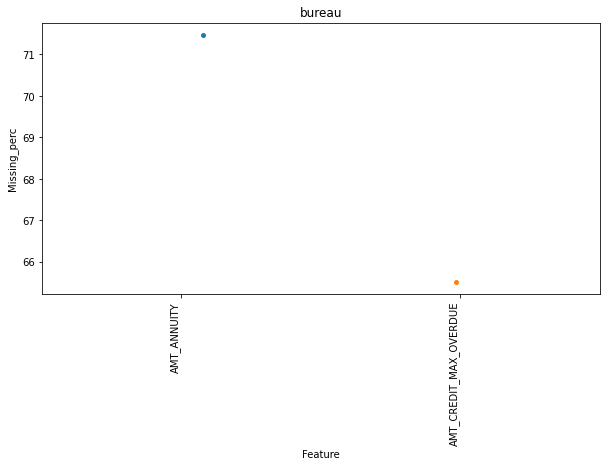

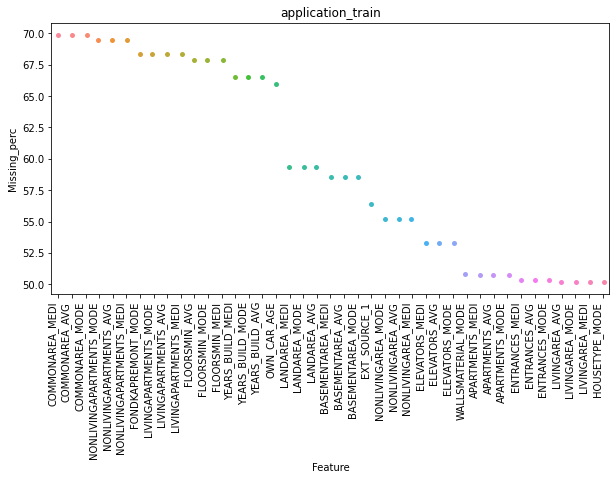

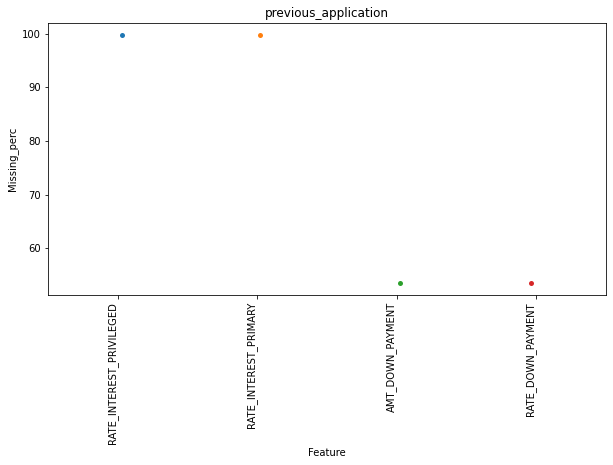

In [ ]:
threshold=50
data2use={}   # values to use in the project

for table in keys_files:
  filename=table + '.csv'
  file = path_data[table]
  if filename in file:
      data_raw =pd.read_csv(file, encoding = "ISO-8859-1")
      data2use=missing_values(data_raw,table,data2use, threshold)
  

###### Transformation des variables categorielles en numeriques

In [ ]:
# Convertir les variables categorieles en numeriques
for table in keys_files:
  data2use=convert_categorical2numeric(data2use,table)



NAME_CONTRACT_STATUS
CREDIT_ACTIVE
CREDIT_CURRENCY
CREDIT_TYPE
NAME_CONTRACT_STATUS
NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
NAME_TYPE_SUITE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
OCCUPATION_TYPE
WEEKDAY_APPR_PROCESS_START
ORGANIZATION_TYPE
EMERGENCYSTATE_MODE
NAME_CONTRACT_TYPE
WEEKDAY_APPR_PROCESS_START
FLAG_LAST_APPL_PER_CONTRACT
NAME_CASH_LOAN_PURPOSE
NAME_CONTRACT_STATUS
NAME_PAYMENT_TYPE
CODE_REJECT_REASON
NAME_TYPE_SUITE
NAME_CLIENT_TYPE
NAME_GOODS_CATEGORY
NAME_PORTFOLIO
NAME_PRODUCT_TYPE
CHANNEL_TYPE
NAME_SELLER_INDUSTRY
NAME_YIELD_GROUP
PRODUCT_COMBINATION
STATUS


######  Imputation de valeurs manquantes

In [ ]:

# Imputer les valeur manquantes par la moyenne
for table in keys_files:
  data2use=fill_remain_missing_val(data2use,table)


In [ ]:
data2use['installments_payments'].head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.00,6,"-1,180.00","-1,187.00","6,948.36","6,948.36"
1,1330831,151639,0.00,34,"-2,156.00","-2,156.00","1,716.53","1,716.53"
2,2085231,193053,2.00,1,-63.00,-63.00,"25,425.00","25,425.00"
3,2452527,199697,1.00,3,"-2,418.00","-2,426.00","24,350.13","24,350.13"
4,2714724,167756,1.00,2,"-1,383.00","-1,366.00","2,165.04","2,160.59"


###### Fusionner bureau et bureau_balance

In [ ]:
# fusionner bureau et bureau_balance car le solde du bureau n'a pas SK_ID_CURR
data2use['bureau_all']= data2use['bureau'].merge(data2use['bureau_balance'],on='SK_ID_BUREAU',how='left')


In [ ]:

# supprimer bureau_balance
del data2use['bureau_balance']
del data2use['bureau']
del keys_files['bureau_balance']
del keys_files['bureau']
keys_files['bureau_all']='bureau_all'


### Agregate data en xxxxxx (nome de table)

In [ ]:
dictOfWords={}
fullstring='_ID_'
del keys_files['application_train']  # pas besoin de faire l'agregation pour train 

for table in keys_files:
  listOfStr= data2use[table].columns
  
  for i in listOfStr:
     if fullstring in i:
        listOfStr=listOfStr.drop(i)
        print(i , "C'est une cles, pas besoin d'agréger")
     
  dictOfWords[table] = { i : np.mean for i in listOfStr if fullstring not in i} 
   

SK_ID_PREV C'est une cles, pas besoin d'agréger
SK_ID_CURR C'est une cles, pas besoin d'agréger
SK_ID_PREV C'est une cles, pas besoin d'agréger
SK_ID_CURR C'est une cles, pas besoin d'agréger
SK_ID_PREV C'est une cles, pas besoin d'agréger
SK_ID_CURR C'est une cles, pas besoin d'agréger
SK_ID_PREV C'est une cles, pas besoin d'agréger
SK_ID_CURR C'est une cles, pas besoin d'agréger
SK_ID_CURR C'est une cles, pas besoin d'agréger
SK_ID_BUREAU C'est une cles, pas besoin d'agréger


In [ ]:

for table in keys_files:
    print(table)
    aggr=dictOfWords[table]
    data2use[table]  = data2use[table].groupby(['SK_ID_CURR'],as_index=False).agg(aggr)

installments_payments
credit_card_balance
POS_CASH_balance
previous_application
bureau_all


### Merge tableau

In [ ]:

data_merged_train = copy.deepcopy(data2use['application_train'])

for table in keys_files:
  print(table)
  data_merged_train = data_merged_train.merge(data2use[table],on='SK_ID_CURR',how='left')

installments_payments
credit_card_balance
POS_CASH_balance
previous_application
bureau_all


## Data insights

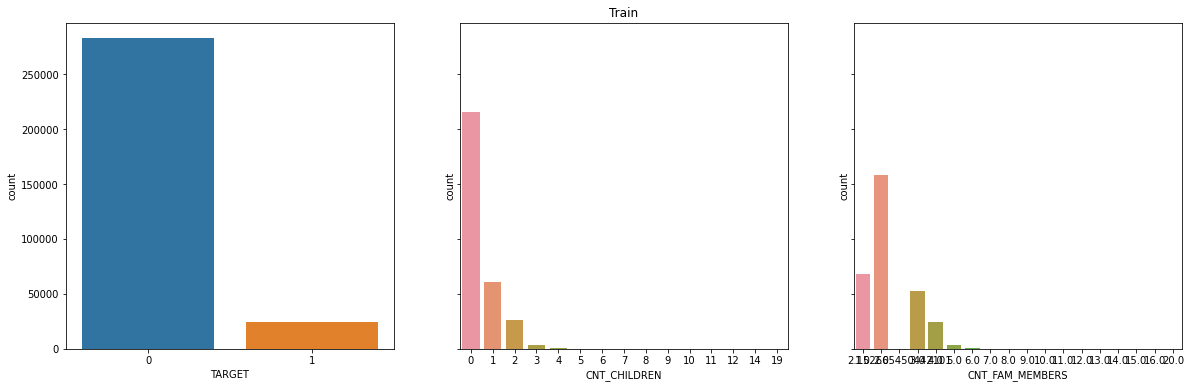

In [ ]:
f, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(20,6),sharey=True)

sns.countplot(data=data_merged_train, x='TARGET',ax=ax1)
sns.countplot(data=data_merged_train, x='CNT_CHILDREN',ax=ax2).set_title('Train')
sns.countplot(data=data_merged_train, x='CNT_FAM_MEMBERS',ax=ax3)


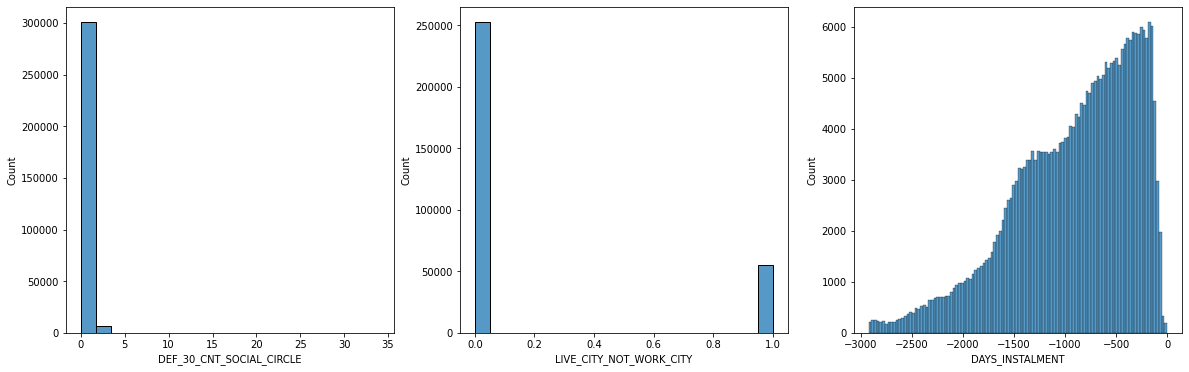

In [ ]:
f, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(20,6))

sns.histplot(data=data_merged_train, x='DEF_30_CNT_SOCIAL_CIRCLE',ax=ax1)
sns.histplot(data=data_merged_train, x='LIVE_CITY_NOT_WORK_CITY',ax=ax2)
sns.histplot(data=data_merged_train, x='DAYS_INSTALMENT',ax=ax3)
#

### Relation entre variables

In [ ]:
coef_correl = data_merged_train.corr()
total_var_before_corel=len(data_merged_train.columns)
print('Taille avant suppression de variables fortement corrélées ' ,total_var_before_corel)

Taille avant suppression de variables fortement corrélées  446


In [ ]:
columns = np.full((coef_correl.shape[0],), True, dtype=bool)
for i in range(coef_correl.shape[0]):
     for j in range(i+1, coef_correl.shape[0]):
        
        if abs(coef_correl.iloc[i,j]) >= 0.9:
            if columns[j]:
                columns[j] = False
                        
selected_columns = data_merged_train.columns[columns]
data_merged_train2use= data_merged_train[selected_columns] 


total_var_after_corel=len(data_merged_train2use.columns)
print('Taille après suppression de variables fortement corrélées ',total_var_after_corel)
print( 'En supprimant les données fortement corrélées, on retire ', total_var_before_corel-total_var_after_corel,' variables')

Taille après suppression de variables fortement corrélées  401
En supprimant les données fortement corrélées, on retire  45  variables


En supprimant les données fortement corrélées, on supprime 46 variables



In [ ]:
if 'TARGET' not in data_merged_train2use.columns:
  data_merged_train2use['TARGET']=data_merged_train['TARGET']



## Données équilibrés ou déséquilibrés?

### Pourcentage des classes (0 et 1) dans la variable cible

In [ ]:
# Regarder target dans train
cat_analyzer(pd.read_csv(path_data['application_train'], encoding = "ISO-8859-1"), "TARGET")


TARGET
    COUNT  RATIO
0  282686   0.92
1   24825   0.08




Il y a une différence très élevée entre les 0 (92 %) et les 1 (8 %) dans la classe cible.

### Rééchantillonnage pour réduire le déséquilibre de l'ensemble de données

In [ ]:

data_merged_train2use= data_merged_train2use.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
X=data_merged_train2use.drop('TARGET',axis=1)
Y=data_merged_train2use['TARGET']

#### Suréchantillonnage

In [ ]:
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state=42)
X_res_over, Y_res_over = sm.fit_resample(X, Y)
X_res_over['TARGET']= Y_res_over

#### Sous-échantillonnage

In [ ]:
from imblearn.under_sampling import RandomUnderSampler 

rus = RandomUnderSampler(random_state=42)
X_res_under, Y_res_under = rus.fit_resample(X, Y)
X_res_under['TARGET']= Y_res_under

## Create csv file with cleaned data

In [ ]:
file=str(dir_data_out) + '/data_merged_train2use.csv'
data_merged_train2use.to_csv(file)

file=str(dir_data_out) + '/data_merged_train2use_over.csv'
X_res_over.to_csv(file)

file=str(dir_data_out) + '/data_merged_train2use_under.csv'
X_res_under.to_csv(file)